# Evaluate the Efficiency of QRes and PINNs

NNs: $H^{(l)} = \sigma[W H^{(l-1)} + b]$

QRes: $H^{(l)} = \sigma[W_1H^{(l-1)} \circ W_2H^{(l-1)} + W_1H^{(l-1)} + b]$

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob

## Configurations

In [2]:
plt.rcParams.update({                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
   'figure.dpi': 300,
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 9,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 7,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    })

## Load Results

In [3]:
num_layers = np.array([2, 4, 6, 8])
num_neurons_pinn = np.array([10, 15, 20, 25, 30, 35, 40])
num_neurons_qres = (num_neurons_pinn / np.sqrt(2)).astype(np.uint)

In [4]:
def qres_param(l, h):
    layer = [2] + [h for i in range(l)] + [1]
    count = 0
    for i in range(len(layer)-1):
        count += layer[i] * layer[i+1] * 2 + layer[i+1]
    return count

def pinn_param(l, h):
    layer = [2] + [h for i in range(l)] + [1]
    count = 0
    for i in range(len(layer)-1):
        count += layer[i] * layer[i+1] + layer[i+1]
    return count

pinn_params = np.zeros((len(num_layers), len(num_neurons_pinn)))
qres_params = np.zeros((len(num_layers), len(num_neurons_qres)))

for i in range(len(num_layers)):
    for j in range(len(num_neurons_qres)):
        qres_params[i, j] = qres_param(num_layers[i], num_neurons_qres[j])
        
for i in range(len(num_layers)):
    for j in range(len(num_neurons_pinn)):
        pinn_params[i, j] = pinn_param(num_layers[i], num_neurons_pinn[j])

In [5]:
errors_pinn = [np.load(file) for file in glob('tables/error_pinn_table*.npy')]
errors_qres = [np.load(file) for file in glob('tables/error_qres_table*.npy')]

df_pinn = []
for error_pinn in errors_pinn:
    df_pinn.append(pd.DataFrame(data={
        'model': np.repeat('PINNs', len(error_pinn.ravel())),
        'error': error_pinn.ravel(),
        'depth': np.repeat(num_layers, len(num_neurons_pinn)),
        'lparams': np.tile(num_neurons_pinn ** 2 + num_neurons_pinn, len(num_layers)),
        'params': pinn_params.ravel()
    }))
df_pinn = pd.concat(df_pinn).reindex()

df_qres = []    
for error_qres in errors_qres:
    df_qres.append(pd.DataFrame(data={
        'model': np.repeat('QRes', len(error_qres.ravel())),
        'error': error_qres.ravel(),
        'depth': np.repeat(num_layers, len(num_neurons_qres)),
        'lparams': np.tile(num_neurons_qres ** 2 * 2 + num_neurons_qres, len(num_layers)),
        'params': qres_params.ravel()
    }))
    
df_qres = pd.concat(df_qres).reindex()
    
df = pd.concat([df_pinn, df_qres]).reindex()

## Stats of PINNs and QRes

In [6]:
print("\nBest of PINNs:")
print(df_pinn[df_pinn.error == df_pinn.error.min()].head(1))
print("\nBest of QRes:")
print(df_qres[df_qres.error == df_qres.error.min()].head(1))
print()
print("\nWorst of PINNs:")
print(df_pinn[df_pinn.error == df_pinn.error.max()].head(1))
print("\nWorst of QRes:")
print(df_qres[df_qres.error == df_qres.error.max()].head(1))
print()
print("\nExpectation of Errors PINNs:")
print("%e" % df_pinn.error.mean())
print("\nExpectation of Errors QRes:")
print("%e" % df_qres.error.mean())


Best of PINNs:
    model     error  depth  lparams  params
10  PINNs  0.000556      4      650  2051.0

Best of QRes:
   model     error  depth  lparams   params
27  QRes  0.000292      8     1596  11369.0


Worst of PINNs:
   model     error  depth  lparams  params
1  PINNs  0.511313      2      240   301.0

Worst of QRes:
  model     error  depth  lparams  params
0  QRes  0.123739      2      105   155.0


Expectation of Errors PINNs:
4.765334e-02

Expectation of Errors QRes:
1.073694e-02


## Plot Overall Distribution

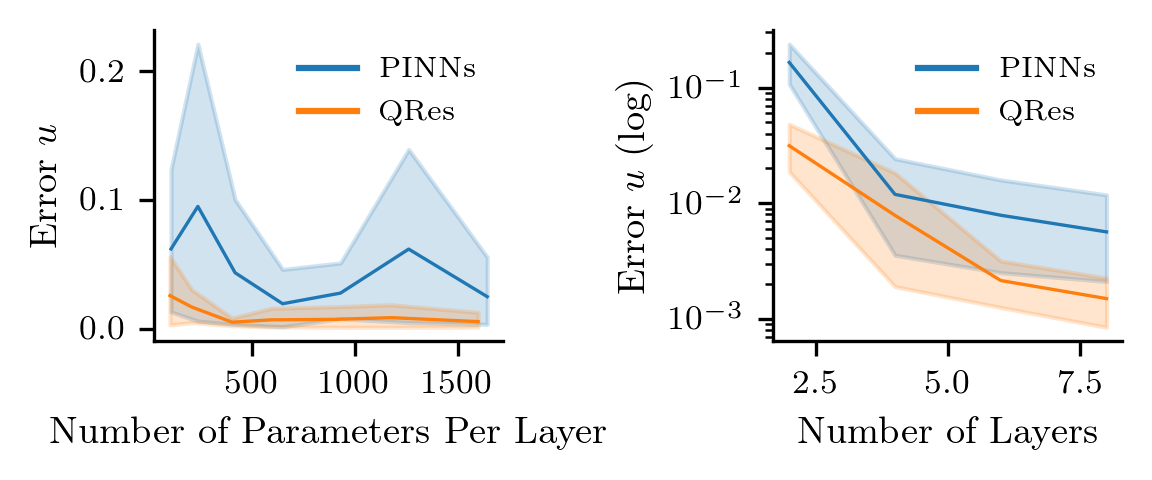

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(4, 1.7), dpi=300)

sns.lineplot(data=df, ax=axes[0], x="lparams", y="error", hue="model", lw=0.8, alpha=1.0)
axes[0].set_xlabel('Number of Parameters Per Layer')
axes[0].set_ylabel('Error $u$')

sns.lineplot(data=df, ax=axes[1], x="depth", y="error", hue="model", lw=0.8, alpha=1.0)
axes[1].set_xlabel('Number of Layers')
axes[1].set_ylabel('Error $u$ (log)')
axes[1].set_yscale('log')

for ax in axes:
    l = ax.get_legend()
    l.set_title('')
    l.get_frame().set_linewidth(0.0)

sns.despine(offset=0)
fig.tight_layout()
fig.savefig('figures/Burgers-efficiency.pdf', dpi=300, bbox_inches='tight')
fig.show()